# Fase

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
%matplotlib widget

## Funciones para propagación

In [2]:
def position_points(array):
    fig, ax = plt.subplots()
    ax.scatter(array[:,:-1], array[:,1:], alpha=.7, color='black', s = 80)
    ax.axis('equal')
    plt.show()

In [3]:
def len_draw(r1, r2, width):
    
    r2 = -r2
    # equation 1
    
    if r1 <= r2:
        # len 1
        x1   = np.linspace(-(r1),0, 500)
        eq1  = np.sqrt( (r1 ** 2) - (x1 ** 2) )
        
        # len 2
        h2   = -np.sqrt( (r2 ** 2) - (r1 ** 2))
        x2   = np.linspace(0,r2+h2, 500)
        eq2  = np.sqrt( (r2 ** 2) - ( (x2 - h2) ** 2) )
    else:
        # len 1
        h1   = np.sqrt( (r1 ** 2) - (r2 ** 2))
        x1   = np.linspace(-r1+h1,0, 500)
        eq1  = np.sqrt( (r1 ** 2) - ( (x1 - h1) ** 2) )
        
        # len 2
        x2   = np.linspace(0,r2, 500)
        eq2  = np.sqrt( (r2 ** 2) - (x2 ** 2) )
        
    # simetric equation 1
    eq12 = np.concatenate(( np.flip(eq1), -eq1 ))
    x12  = np.concatenate(( np.flip(x1), x1 ))
    
    # simetric equation 2
    eq21 = np.concatenate(( np.flip(eq2), -eq2 ))
    x21  = np.concatenate(( np.flip(x2), x2 ))
    
    # draw
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.fill(x12, eq12,facecolor= '#5072A7', alpha = 0.5, label = 'R1')
    ax.fill(x21, eq21,facecolor= '#CD5C5C', alpha = 0.5, label = 'R2')
    ax.legend()
    plt.show()

In [4]:
def matrix_points(p):
    #x son los puntos sobre el eje x
    x = list(np.array(p)[:,0])
    y = list(np.array(p)[:,1])
    
    #subm_1 es la submatriz compuesta de vectores fila de x
    subm_1x = np.array(x*len(x)).reshape(len(x),len(x))
    subm_1y = np.array(y*len(y)).reshape(len(y),len(y))
    
    #subm_2 es la submatriz compuesta de vectores columna repitiendo x
    subm_2x = np.transpose(subm_1x)
    subm_2y = np.transpose(subm_1y)
    
    #xi_a es el promedio de cada punto en x con cada uno de los demas puntos
    xi_a = (subm_1x+subm_2x)/2
    eta_a = (subm_1y+subm_2y)/2
    
    #xi_d es la distancia de cada punto con cada uno de los demas puntos
    xi_d = subm_2x-subm_1x
    eta_d = subm_2y-subm_1y
    
    #vectores de las matrices xi_a y xi_d
    xi_av = list(xi_a.reshape(1,len(xi_a)**2))
    xi_dv = list(xi_d.reshape(1,len(xi_d)**2))
    eta_av = list(eta_a.reshape(1,len(eta_a)**2))
    eta_dv = list(eta_d.reshape(1,len(eta_d)**2))
    
    #matriz con todas las parejas de puntos xi_a y xi_d
    xi_m = np.transpose(np.array(xi_av+xi_dv+eta_av+eta_dv)).reshape(len(x),len(x),4)
    return xi_m

In [5]:
def GeometricPotencial_3D_00_reducido(xa, xi_a, xi_d, ya, eta_a, eta_d, za, wa, c, R1, R2):
    #constantes
    pic = 1 / ((4*np.pi) ** 2)
    k = ((2*np.pi)/wa)
    n = 1.5 #refractive index
    
    xi_p, xi_n = xi_a+(xi_d)/2, xi_a-(xi_d)/2
    eta_p, eta_n = eta_a+(eta_d)/2, eta_a-(eta_d)/2
    
    normPlus  = (xi_p**2) + (eta_p**2)
    normMinus = (xi_n**2) + (eta_n**2)
    
    
    # fase dentro y fuera de la lente para +
    if (normPlus > (R1 ** 2)) or (normPlus > (R2 ** 2)):
        phase_plus = 0
    else:
        phase_plus  = R1 * np.sqrt(1 - (normPlus / (R1 ** 2)) + 0j) - R2 * np.sqrt(1 - (normPlus / (R2 ** 2)) + 0j)
        
    # fase dentro y fuera de la lente para -
    if (normMinus > (R1 ** 2)) or (normMinus > (R2 ** 2)):
        phase_minus = 0
    else:
        phase_minus = R1 * np.sqrt(1 - (normMinus / (R1 ** 2)) + 0j) - R2 * np.sqrt(1 - (normMinus / (R2 ** 2)) + 0j)
    
    phase = np.exp(1j*(n-1)*k*phase_plus*c) * np.exp(-1j*(n-1)*k*phase_minus*c)
    
    #distancia s
    s_1 = np.sqrt(((xa-xi_p) ** 2) + ((ya-eta_p) **2) + ((za) ** 2))
    s_2 = np.sqrt(((xa-xi_n) **2) + ((ya-eta_n) ** 2) + ((za) ** 2))
    
    #kernel
    kernel_0 = 2*((k**2)*pic) * ((za+s_1)/(s_1 ** 2)) * ((za+s_2)/(s_2 ** 2)) * np.exp(1j*k*s_1-1j*k*s_2) * phase 

    kernel = np.real(kernel_0)
    
    #print(phase)
    return kernel

def GeometricPotencial_3D_Real(xa, ya, za, p, wa,c,R1,R2):
    sum_r = 0
    matrix_complete = matrix_points(p)
    matrix_real = np.einsum('iij->ij', matrix_complete)
    for i in matrix_real:
        sum_r = sum_r + GeometricPotencial_3D_00_reducido(xa,i[0],i[1],ya,i[2],i[3],za,wa,c,R1,R2)
    return sum_r

def GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c,R1,R2):
    sum_v = 0
    matrix_complete = matrix_points(p)
    matrix_virtual = []
    
    for i in range(0,len(matrix_complete)):
        for j in range(0,len(matrix_complete)):
            if i != j:
                matrix_virtual.append(list(matrix_complete[i,j]))
    
    matrix_virtual = np.array(matrix_virtual)
    
    for k in matrix_virtual:
        sum_v = sum_v + GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa,c,R1,R2)
        #sum_v = GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa,c,R1,R2)
    return sum_v

def GeometricPotencial_3D_reducido(xa, ya, za, p, wa,c,R1,R2):
    sum_t = 1*GeometricPotencial_3D_Real(xa, ya, za, p, wa,c,R1,R2) + 1*GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c,R1,R2)
    return sum_t

In [6]:
# longitud de onda
w = 400 * (10 ** -9)

# radios de la lente
r1 = 5*w
r2 = -6*w

# radios para diferencia de fases
rho_1 = 2.23*w
rho_2 = 4.013*w
rho_3 = 1.615*w
rho_4 = 2.665*w
rho_5 = 3.006*w

# pi
pi = np.pi

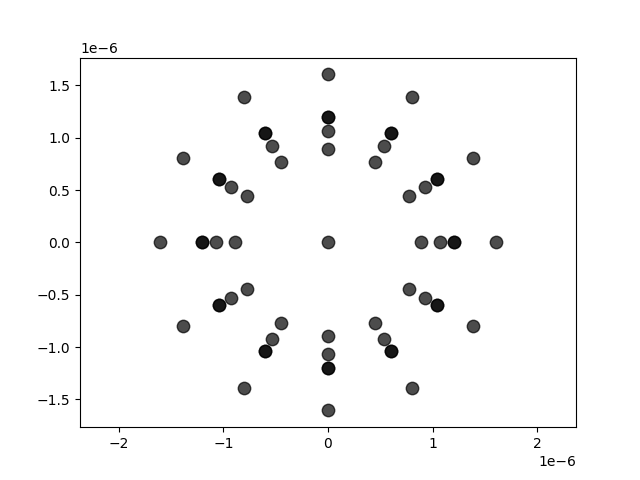

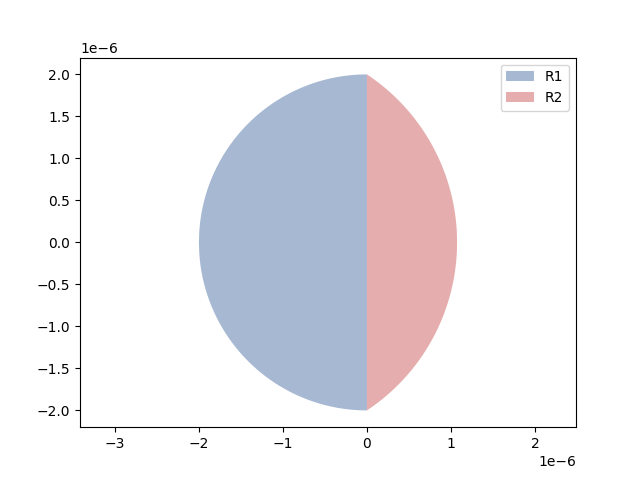

In [11]:
# puntos primera circunferencia
points_1 = rho_1*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/6),np.sin(pi/6)], [np.cos(pi/3),np.sin(pi/3)], [np.cos(pi/2),np.sin(pi/2)], [np.cos((pi*2)/3),np.sin((pi*2)/3)], [np.cos((pi*5)/6),np.sin((pi*5)/6)], [np.cos(pi),np.sin(pi)], [np.cos(-pi/6),np.sin(-pi/6)], [np.cos(-pi/3),np.sin(-pi/3)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos((-pi*2)/3),np.sin((-pi*2)/3)], [np.cos((-pi*5)/6),np.sin((-pi*5)/6)]])
#points_1 = 

# puntos segunda circunferencia
points_2 = rho_2*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/6),np.sin(pi/6)], [np.cos(pi/3),np.sin(pi/3)], [np.cos(pi/2),np.sin(pi/2)], [np.cos((pi*2)/3),np.sin((pi*2)/3)], [np.cos((pi*5)/6),np.sin((pi*5)/6)], [np.cos(pi),np.sin(pi)], [np.cos(-pi/6),np.sin(-pi/6)], [np.cos(-pi/3),np.sin(-pi/3)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos((-pi*2)/3),np.sin((-pi*2)/3)], [np.cos((-pi*5)/6),np.sin((-pi*5)/6)]])
#points_2 = rho_2*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/2),np.sin(pi/2)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos(pi),np.sin(pi)]])

# puntos segunda circunferencia
points_5 = rho_5*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/6),np.sin(pi/6)], [np.cos(pi/3),np.sin(pi/3)], [np.cos(pi/2),np.sin(pi/2)], [np.cos((pi*2)/3),np.sin((pi*2)/3)], [np.cos((pi*5)/6),np.sin((pi*5)/6)], [np.cos(pi),np.sin(pi)], [np.cos(-pi/6),np.sin(-pi/6)], [np.cos(-pi/3),np.sin(-pi/3)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos((-pi*2)/3),np.sin((-pi*2)/3)], [np.cos((-pi*5)/6),np.sin((-pi*5)/6)]])


points_3 = rho_3*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/6),np.sin(pi/6)], [np.cos(pi/3),np.sin(pi/3)], [np.cos(pi/2),np.sin(pi/2)], [np.cos((pi*2)/3),np.sin((pi*2)/3)], [np.cos((pi*5)/6),np.sin((pi*5)/6)], [np.cos(pi),np.sin(pi)], [np.cos(-pi/6),np.sin(-pi/6)], [np.cos(-pi/3),np.sin(-pi/3)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos((-pi*2)/3),np.sin((-pi*2)/3)], [np.cos((-pi*5)/6),np.sin((-pi*5)/6)]])

points_4 = rho_4*np.array([[np.cos(0),np.sin(0)], [np.cos(pi/6),np.sin(pi/6)], [np.cos(pi/3),np.sin(pi/3)], [np.cos(pi/2),np.sin(pi/2)], [np.cos((pi*2)/3),np.sin((pi*2)/3)], [np.cos((pi*5)/6),np.sin((pi*5)/6)], [np.cos(pi),np.sin(pi)], [np.cos(-pi/6),np.sin(-pi/6)], [np.cos(-pi/3),np.sin(-pi/3)], [np.cos(-pi/2),np.sin(-pi/2)], [np.cos((-pi*2)/3),np.sin((-pi*2)/3)], [np.cos((-pi*5)/6),np.sin((-pi*5)/6)]])

# zero
point_zero = np.array([[0,0]])

# puntos totales
points = np.concatenate(( points_1, points_2 ))
points = np.concatenate(( points, point_zero ))
#points = np.concatenate(( points, points_3 ))
points = np.concatenate(( points, points_5 ))
points = np.concatenate(( points, points_4 ))
points = np.concatenate(( points, points_5 ))

position_points(points)
len_draw(r1,r2,0)

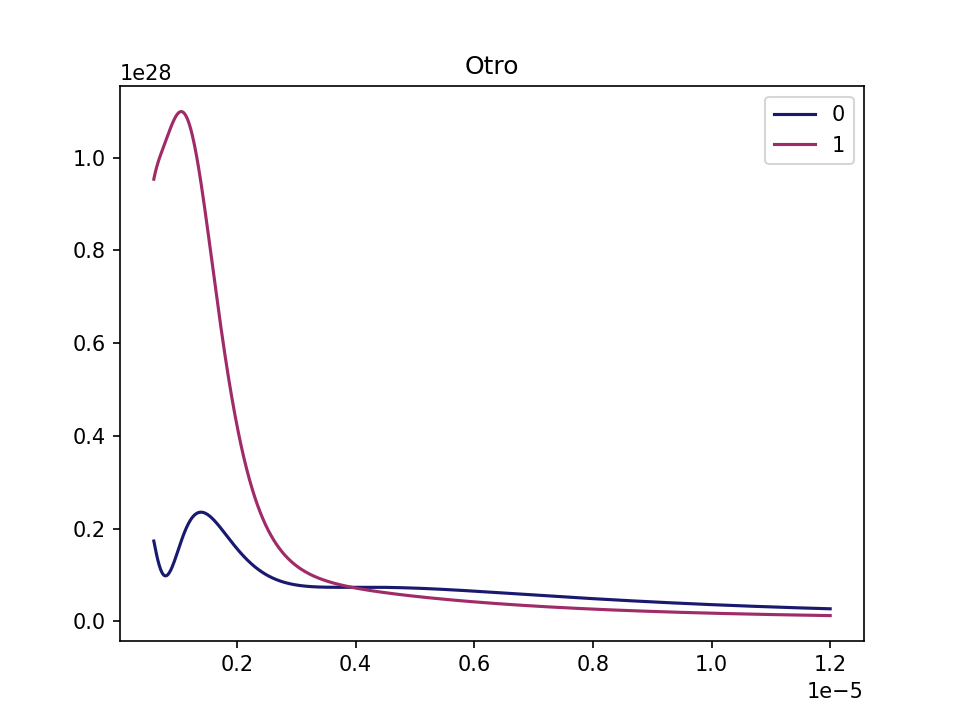

CPU times: user 1.01 s, sys: 199 ms, total: 1.21 s
Wall time: 996 ms


In [12]:
%%time
zzz = np.linspace(1.5*w, 30*w, 1000)
z_plot_0 = np.array(list(GeometricPotencial_3D_reducido(0*w,0,zzz,points,w,0,r1,r2)), dtype=float)
z_plot_1 = np.array(list(GeometricPotencial_3D_reducido(0*w,0,zzz,points,w,1,r1,r2)), dtype=float)

fig, ax = plt.subplots(dpi=150)
ax.plot(zzz, z_plot_0, label="0", color="#191970")
ax.plot(zzz, z_plot_1, label="1", color="#9F2B68")
ax.legend()
ax.set_title("Otro")
plt.show()

## Foco